In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"herutriana","key":"af436e428852deadc1ebbc46c34612b1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iansangaji/mangga

mangga.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile,os
zip_lcl = '/content/mangga.zip'
rzip = zipfile.ZipFile(zip_lcl, 'r')
rzip.extractall('/content')
rzip.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [ ]:
BATCH_SIZE = 60
IMAGE_SIZE = 256
EPOCHS=62
CHANNELS=3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/mangga_image/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 198 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['mangga_busuk', 'mangga_masak', 'mangga_muda']

In [ ]:
len(dataset)

4

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(60, 256, 256, 3)
tf.Tensor(
[[[ 21.16275   57.815125  23.220352]
  [ 29.679718  65.28519   32.434586]
  [ 34.240433  71.97977   36.917465]
  ...
  [134.30113  129.36894  128.83504 ]
  [134.92776  129.53323  129.2305  ]
  [132.46356  127.765625 127.11459 ]]

 [[ 23.924728  63.517517  28.153336]
  [ 24.432571  63.578125  27.852768]
  [ 20.642578  56.74489   23.152496]
  ...
  [117.19847  113.12245  112.16046 ]
  [143.58221  138.33984  137.96103 ]
  [155.20796  150.81151  150.00974 ]]

 [[ 26.804886  68.23102   28.639572]
  [ 26.342697  66.37816   30.072418]
  [ 24.027344  63.457428  27.887512]
  ...
  [135.57521  130.57991  130.07756 ]
  [151.64648  146.6546   146.15054 ]
  [157.39879  153.39879  152.39879 ]]

 ...

 [[ 31.626602  30.107422  21.981369]
  [ 24.559036  22.77359   16.251053]
  [ 18.024796  17.20137   12.789459]
  ...
  [136.73106  135.30098  136.01602 ]
  [133.86523  132.83789  133.35156 ]
  [131.48633  130.0602   129.63957 ]]

 [[ 35.897446  32.50099   24.492126]
  [ 27.6

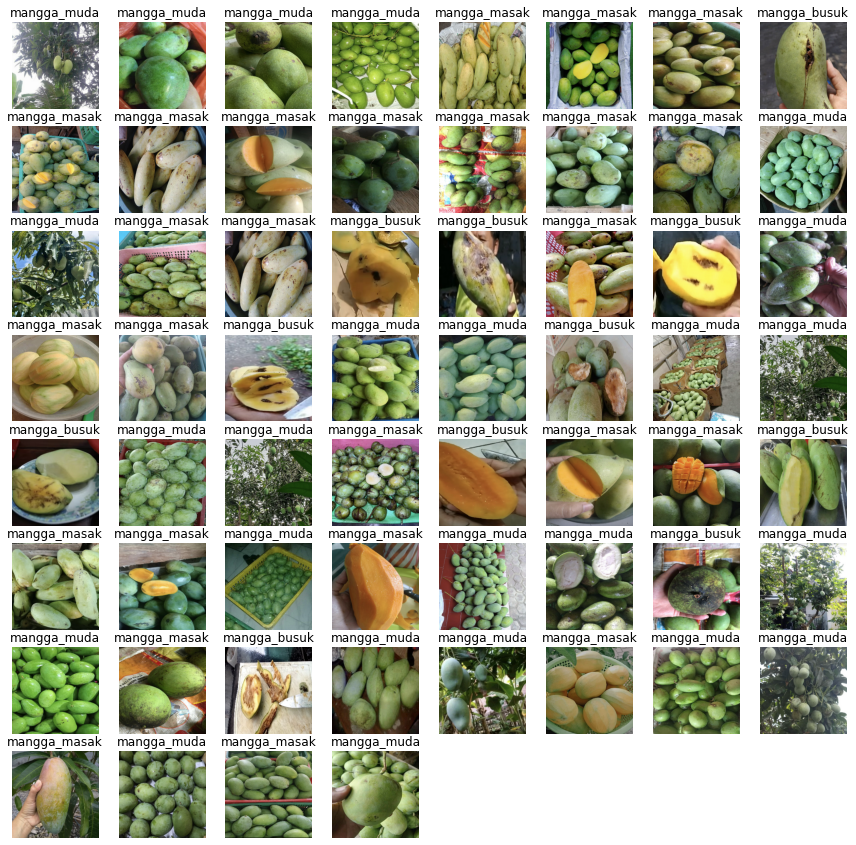

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, test_split=0.0, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (60, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (60, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (60, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (60, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (60, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (60, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=EPOCHS,
)

Epoch 1/62
3/3 - 16s - loss: 2.1578 - accuracy: 0.3478 - 16s/epoch - 5s/step
Epoch 2/62
3/3 - 0s - loss: 1.7130 - accuracy: 0.3623 - 279ms/epoch - 93ms/step
Epoch 3/62
3/3 - 0s - loss: 1.4499 - accuracy: 0.3768 - 282ms/epoch - 94ms/step
Epoch 4/62
3/3 - 0s - loss: 1.2019 - accuracy: 0.3841 - 279ms/epoch - 93ms/step
Epoch 5/62
3/3 - 0s - loss: 1.1102 - accuracy: 0.3116 - 279ms/epoch - 93ms/step
Epoch 6/62
3/3 - 0s - loss: 1.1114 - accuracy: 0.3623 - 280ms/epoch - 93ms/step
Epoch 7/62
3/3 - 0s - loss: 1.0991 - accuracy: 0.3333 - 279ms/epoch - 93ms/step
Epoch 8/62
3/3 - 0s - loss: 1.0838 - accuracy: 0.3841 - 279ms/epoch - 93ms/step
Epoch 9/62
3/3 - 0s - loss: 1.0957 - accuracy: 0.3986 - 280ms/epoch - 93ms/step
Epoch 10/62
3/3 - 0s - loss: 1.0756 - accuracy: 0.3478 - 280ms/epoch - 93ms/step
Epoch 11/62
3/3 - 0s - loss: 1.0883 - accuracy: 0.3913 - 279ms/epoch - 93ms/step
Epoch 12/62
3/3 - 0s - loss: 1.0720 - accuracy: 0.4130 - 280ms/epoch - 93ms/step
Epoch 13/62
3/3 - 0s - loss: 1.0946 - ac

In [ ]:
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.6399 - accuracy: 0.6667


[0.6399385929107666, 0.6666666865348816]

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

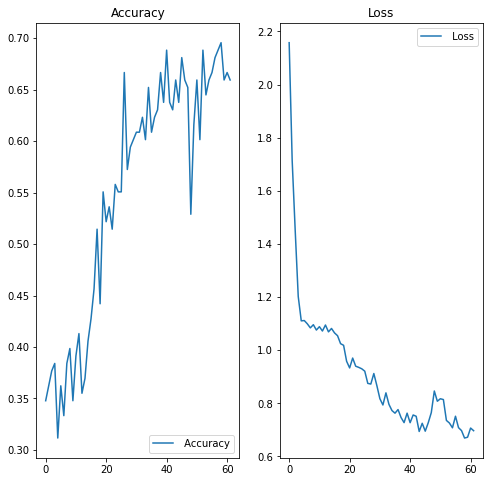

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

mangga_masak


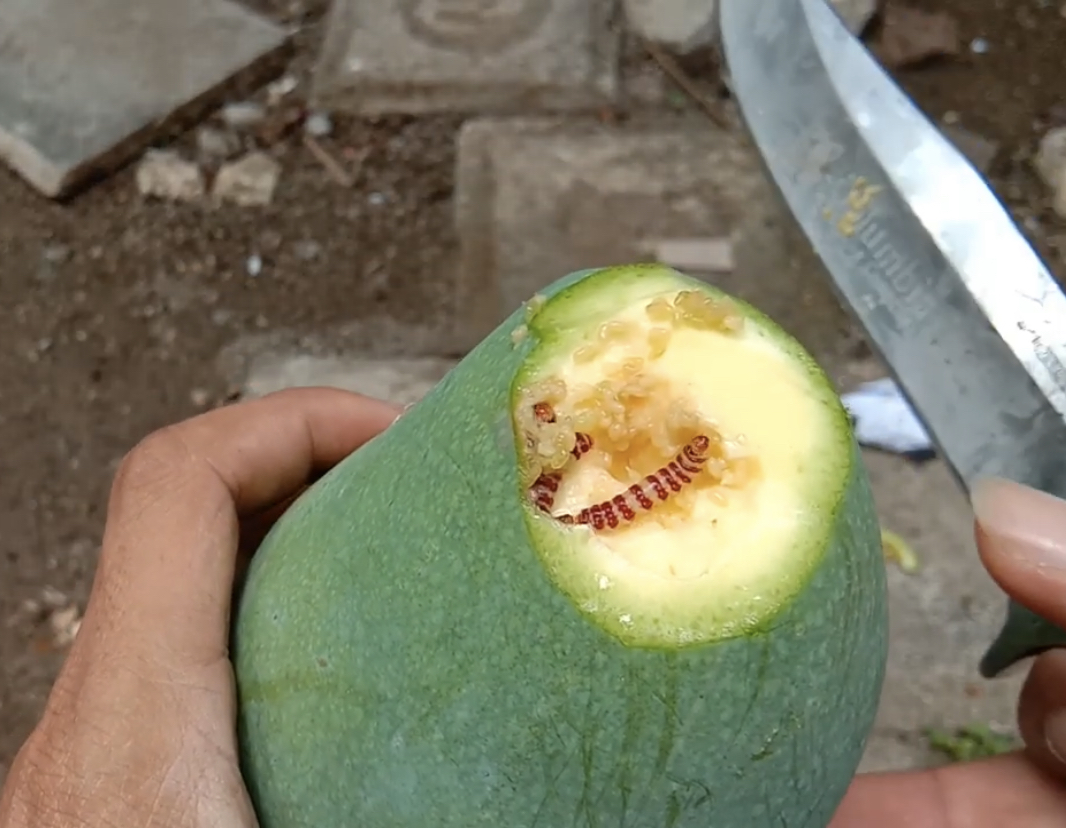

In [ ]:
image_path = "/content/mangga_image/valid/mangga_busuk/Mangga busuk 100.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
pred = model.predict(scaled_img)
output = class_names[np.argmax(pred)]
print(output)
image

mangga_masak


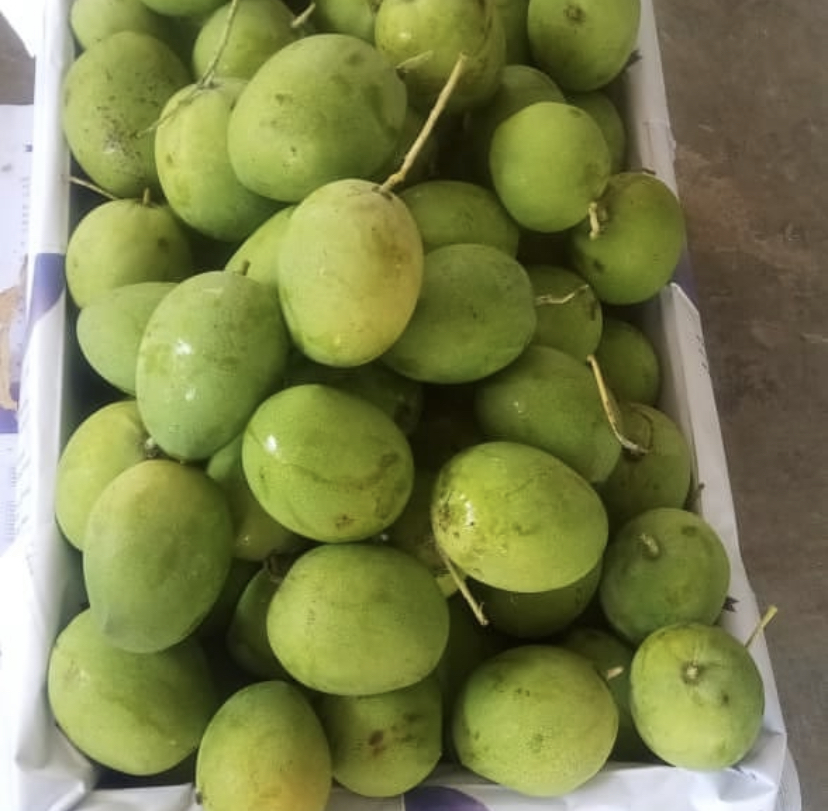

In [ ]:
image_path = "/content/mangga_image/valid/mangga_masak/Mangga masak  30.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
pred = model.predict(scaled_img)
output = class_names[np.argmax(pred)]
print(output)
image

mangga_muda


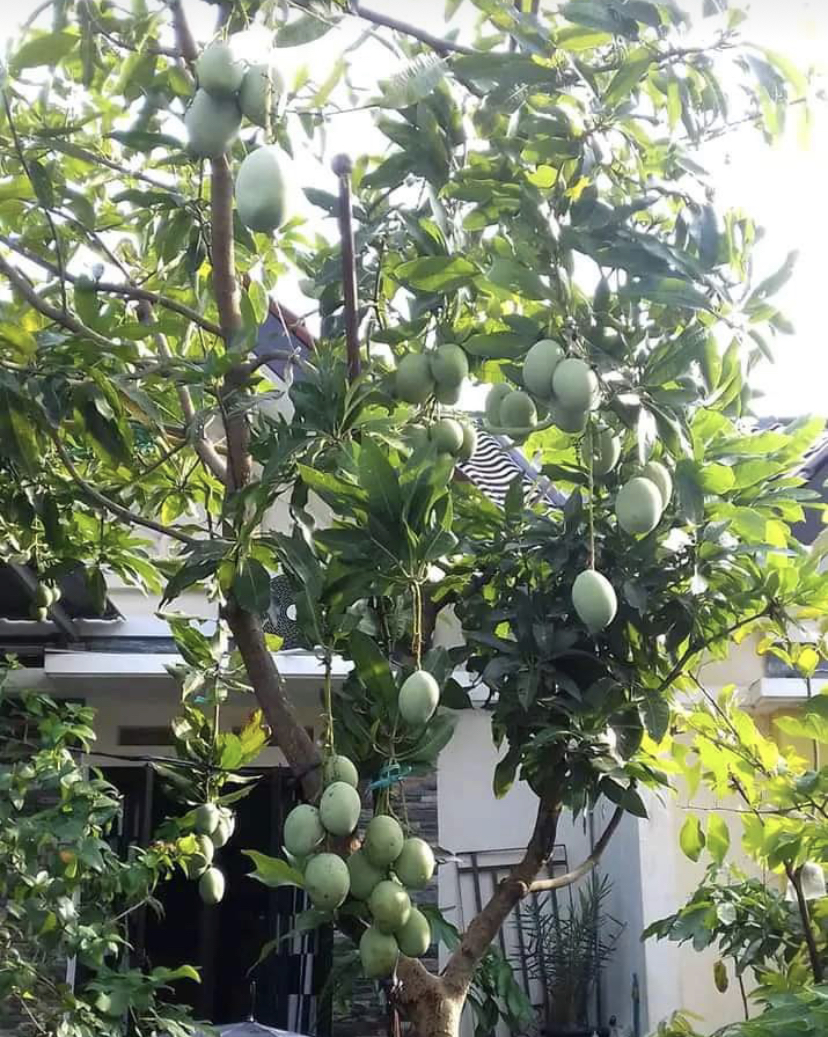

In [ ]:
image_path = "/content/mangga_image/valid/mangga_muda/IMG_6212.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
pred = model.predict(scaled_img)
output = class_names[np.argmax(pred)]
print(output)
image

In [ ]:
model.save("Klasifikasi Tingkat Kematangan Mangga.h5")